In [1]:
import cmocean.cm as cm
import datetime as dt
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

from salishsea_tools import viz_tools

In [2]:
mesh = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc')
bathy = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
kk = np.array([0.74711466, 3.54136997, 0.37895037, 7.19318921, 0.42550747])

In [4]:
def growth(k, pH, co2):
    mm = co2/(k[1] + co2)
    tt = k[0] * (1 + k[2] * (1 + np.tanh((pH - k[3]) / k[4])))
    return mm * tt, mm, tt

In [5]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

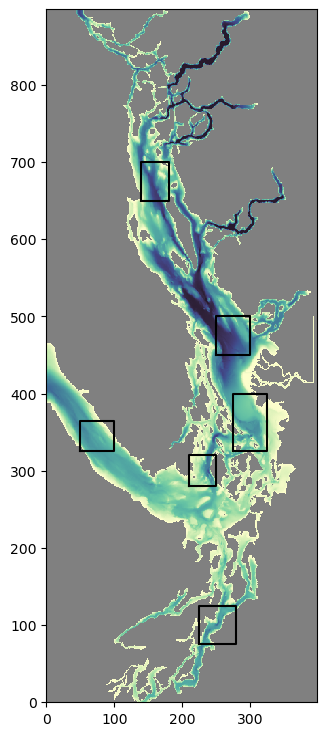

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);
CentralSoG = [450,500, 250, 300]
plot_box(ax, CentralSoG, 'k')

NorthernSoG = [650,700, 140,180]
plot_box(ax, NorthernSoG, 'k')

SouthernSoG = [325,400, 275, 325]
plot_box(ax, SouthernSoG, 'k')

Mixed = [280,320, 210, 250]
plot_box(ax, Mixed, 'k')

JdF = [325,365, 50, 100]

plot_box(ax, JdF, 'k')

PS_main = [75,125, 225, 280]
plot_box(ax, PS_main, 'k')

SS_all = [0, 898, 0, 398]

boxes = [SS_all, SouthernSoG,CentralSoG, NorthernSoG, PS_main, Mixed, JdF]
boxnames = ['SS_all', 'SouthernSoG', 'CentralSoG', 'NorthernSoG', 'PS_main', 'Mixed',
           'JdF']

In [7]:
def get_diatoms(files):
    diatoms = []
    times = []
    skipped_files = []
    for file in files:
        try:
            neutral = xr.open_dataset(file)
            diatom_data = np.ma.masked_where(
                tmask[0, 0:5, SS_all[0]:SS_all[1], SS_all[2]:SS_all[3]] == 0,
                neutral.diatoms[0, 0:5, SS_all[0]:SS_all[1], SS_all[2]:SS_all[3]]
            ).mean()
            diatoms.append(diatom_data)
            times.append(neutral.time_centered[0].values)
            neutral.close()
        except Exception as e:
            skipped_files.append((file, f"exception: {e}"))
            continue

    return diatoms, times, skipped_files

In [8]:
files = sorted(glob.glob('/data/sallen/results/MEOPAR/Karyn/Carbon_v202111/Present_Lb80/*/SalishSea_1d*_ptrc_T.nc'))

# Extract date from filename for true chronological sort
def extract_date(file_path):
    filename = os.path.basename(file_path)
    return filename.split('_')[2]  # This is 'YYYYMMDD'

# Sort files by date in filename
files = sorted(files, key=extract_date)

diatoms_Lb80, times_Lb80, skipped_files = get_diatoms(files)

In [9]:
for file, reason in skipped_files:
    print(f"Skipped: {file} → {reason}")

In [10]:
files = sorted(glob.glob('/data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/*/SalishSea_1d*_ptrc_T.nc'))

# Extract date from filename for true chronological sort
def extract_date(file_path):
    filename = os.path.basename(file_path)
    return filename.split('_')[2]  # This is 'YYYYMMDD'

# Sort files by date in filename
files = sorted(files, key=extract_date)

diatoms_PI_Lb80, times_PI_Lb80, skipped_files_PI = get_diatoms(files)

In [11]:
for file, reason in skipped_files_PI:
    print(f"Skipped: {file} → {reason}")

Skipped: /data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/30dec11/SalishSea_1d_20111230_20111230_ptrc_T.nc → exception: zero-size array to reduction operation minimum which has no identity


(0.0, 6.0)

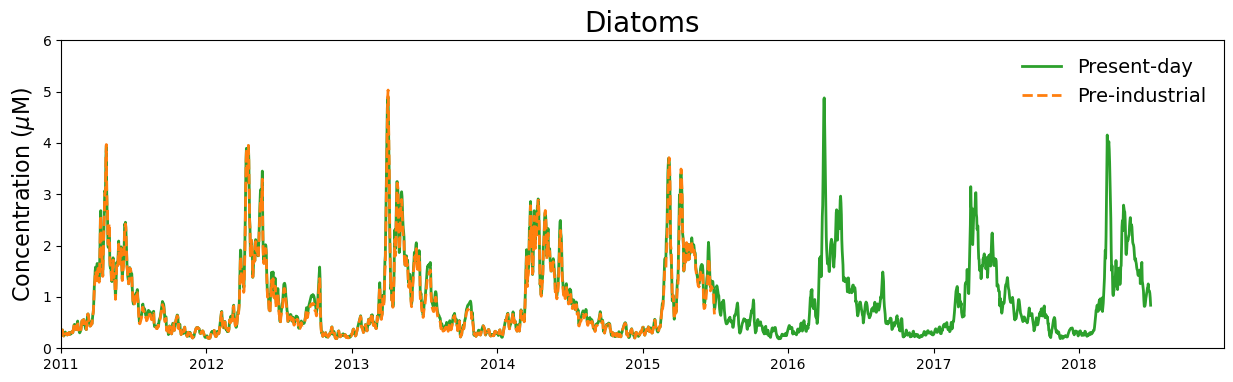

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
#blue, = ax.plot(times_noI, diatoms_noI, '-', c='tab:blue', linewidth=2)
#bluedsh, = ax.plot(times_PI_noI, diatoms_PI_noI, '--', c='tab:blue')
green, = ax.plot(times_Lb80, diatoms_Lb80, '-', c='tab:green', linewidth=2)
greendsh, = ax.plot(times_PI_Lb80, diatoms_PI_Lb80, '--', c='tab:orange',linewidth=2)
#green, = ax.plot(times_wC90, diatoms_wC90, '-', c='tab:green', linewidth=2)
#greendsh, = ax.plot(times_PI_wC90, diatoms_PI_wC90, '--', c='tab:green')
ax.legend([green, greendsh], #blue, bluedsh,
          [ "Present-day", 'Pre-industrial'],fontsize=14,frameon=False); #"no Impact",'pre-industrial',
ax.set_xlim((dt.datetime(2011, 1, 1), dt.datetime(2018, 12, 31)))
#ax.grid();
ax.set_title('Diatoms',fontsize=20)
ax.set_ylabel('Concentration ($\mu$M)',fontsize=16)
ax.set_ylim(0,6)

#plt.savefig('PDvsPI_Diatoms_SalishSea.png', bbox_inches='tight',dpi=1000,transparent=False)